# Multilingual Data Preprocessing for LitBank NER

## Overview
This notebook prepares English, French, and Italian LitBank datasets with literary texts for multilingual transformer-based Named Entity Recognition (NER).

**Content**
1. Load English LitBank data from HuggingFace
2. Load French and Italian LitBank data from BRAT format
3. Harmonize entity types across languages
4. Parse BIO-tagged annotations
5. Convert to JSON format for transformer training
6. Generate statistics and visualizations
7. Create language-specific datasets

**Entity Type Harmonization:**
- English and Italian: PER, LOC, GPE, ORG, FAC, VEH
- French: PER, LOC, GPE, ORG, FAC, VEH, TIME (+ some special types that will be mapped)

**Common**: PER, LOC, GPE, ORG, FAC, VEH, TIME

## 1. Setup and Imports

In [1]:
# Import required libraries
import os
import json
import re
import pandas as pd
from pathlib import Path
from typing import List, Dict, Tuple
from collections import Counter, defaultdict
import matplotlib.pyplot as plt
from tqdm import tqdm
from datasets import load_dataset

# Configure paths
RAW_DATA_PATH = Path("../data/raw")
PROCESSED_DATA_PATH = Path("../data/processed")
RESULTS_PATH = Path("../results")

# Create directories
PROCESSED_DATA_PATH.mkdir(parents=True, exist_ok=True)
RESULTS_PATH.mkdir(parents=True, exist_ok=True)
RAW_DATA_PATH.mkdir(parents=True, exist_ok=True)

print("✓ Libraries imported")
print(f"✓ Processed data will be saved to: {PROCESSED_DATA_PATH.absolute()}")
print(f"✓ Results will be saved to: {RESULTS_PATH.absolute()}")

✓ Libraries imported
✓ Processed data will be saved to: /storage/homefs/nw03x063/CAS_Mod4_NER/notebooks/../data/processed
✓ Results will be saved to: /storage/homefs/nw03x063/CAS_Mod4_NER/notebooks/../results


## 2. Entity Type Mapping Configuration

Define the harmonization strategy for entity types across languages.

In [2]:
# French-specific entity type mappings
FRENCH_ENTITY_MAPPING = {
    'NO_PER': 'PER',      # Non-person entities → Person
    'HIST': 'TIME',       # Historical references → Time
}

# French entity types to drop (will become 'O')
FRENCH_DROP_TYPES = {'METALEPSE', 'None', 'OTHER', 'TO_DISCUSS'}

# Italian-specific entity type mappings
ITALIAN_ENTITY_MAPPING = {}

# Italian entity types to drop (will become 'O')
ITALIAN_DROP_TYPES = set()

# Common entity types across all languages (after mapping)
COMMON_ENTITY_TYPES = ['PER', 'LOC', 'GPE', 'ORG', 'FAC', 'VEH', 'TIME']

print("Entity Type Harmonization Strategy:")
print(f"\nFrench mappings:")
for original, mapped in FRENCH_ENTITY_MAPPING.items():
    print(f"  {original} → {mapped}")

print(f"\nFrench types to drop:")
for drop_type in sorted(FRENCH_DROP_TYPES):
    print(f"  {drop_type} → O")

print(f"\nItalian mappings:")
if ITALIAN_ENTITY_MAPPING:
    for original, mapped in ITALIAN_ENTITY_MAPPING.items():
        print(f"  {original} → {mapped}")
else:
    print("  (none - uses standard entity types)")

print(f"\nItalian types to drop:")
if ITALIAN_DROP_TYPES:
    for drop_type in sorted(ITALIAN_DROP_TYPES):
        print(f"  {drop_type} → O")
else:
    print("  (none)")

print(f"\nCommon entity types (final):")
print(f"  {', '.join(COMMON_ENTITY_TYPES)}")

Entity Type Harmonization Strategy:

French mappings:
  NO_PER → PER
  HIST → TIME

French types to drop:
  METALEPSE → O
  None → O
  OTHER → O
  TO_DISCUSS → O

Italian mappings:
  (none - uses standard entity types)

Italian types to drop:
  (none)

Common entity types (final):
  PER, LOC, GPE, ORG, FAC, VEH, TIME


## 3. English LitBank: Download and Processing Functions

In [3]:
def download_english_litbank():
    """
    Download English LitBank from HuggingFace and convert to BIO format.
    Uses cascading layer strategy to extract entity annotations.
    """
    print("DOWNLOADING ENGLISH LITBANK")
    
    # Create directories for English data
    english_dir = RAW_DATA_PATH / "english"
    for split_name in ['train', 'dev', 'test']:
        (english_dir / split_name).mkdir(parents=True, exist_ok=True)
    
    print("\nDownloading from HuggingFace...")
    dataset = load_dataset("coref-data/litbank_raw", "split_0")
    
    # Map validation to dev
    split_mapping = {
        'train': 'train',
        'validation': 'dev',
        'test': 'test'
    }
    
    print("\nConverting to BIO format...")
    
    layer_usage_stats = {layer: 0 for layer in range(5)}
    total_tokens_processed = 0
    
    for hf_split, our_split in split_mapping.items():
        split_data = dataset[hf_split]
        split_dir = english_dir / our_split
        
        print(f"\nProcessing {our_split} split ({len(split_data)} documents)...")
        
        for idx, example in enumerate(split_data):
            doc_name = example['doc_name']
            sentences = example['sentences']
            entities = example['entities']
            
            output_file = split_dir / f"{doc_name}.tsv"
            
            with open(output_file, 'w', encoding='utf-8') as f:
                for sent_idx, sentence in enumerate(sentences):
                    if sent_idx < len(entities):
                        entity_annotations = entities[sent_idx]
                        
                        for token_dict in entity_annotations:
                            token = token_dict['token']
                            bio_tags = token_dict['bio_tags']
                            
                            # Cascading layer strategy
                            tag = 'O'
                            layer_used = -1
                            
                            for layer_idx, t in enumerate(bio_tags):
                                if t and t.strip():
                                    if t != 'O':
                                        tag = t
                                        layer_used = layer_idx
                                        break
                                    elif tag == 'O':
                                        tag = 'O'
                                        layer_used = layer_idx
                            
                            if layer_used >= 0:
                                layer_usage_stats[layer_used] += 1
                            total_tokens_processed += 1
                            
                            f.write(f"{token}\t{tag}\n")
                    else:
                        for token in sentence:
                            f.write(f"{token}\tO\n")
                            total_tokens_processed += 1
                    
                    f.write("\n")
        
        print(f"  ✓ Saved {len(split_data)} documents to {split_dir}/")
    
    print("English LitBank download complete!")
    print(f"\nTotal tokens processed: {total_tokens_processed:,}")
    
    return english_dir

# Download English data
english_data_dir = download_english_litbank()

DOWNLOADING ENGLISH LITBANK


Converting to BIO format...

Processing train split (80 documents)...
  ✓ Saved 80 documents to ../data/raw/english/train/

Processing dev split (10 documents)...
  ✓ Saved 10 documents to ../data/raw/english/dev/

Processing test split (10 documents)...
  ✓ Saved 10 documents to ../data/raw/english/test/
English LitBank download complete!

Total tokens processed: 210,532


## 4a. French LitBank: BRAT to BIO Converter

In [20]:
class BratToBioConverter:
    """
    Converts BRAT format annotations to BIO-tagged format.
    Accepts ALL entity types and applies mapping during conversion.
    """
    
    def __init__(self, entity_mapping=None, drop_types=None):
        """Initialize converter with optional entity type mapping."""
        self.entity_mapping = entity_mapping or {}
        self.drop_types = drop_types or set()
        self.discovered_types = set()
    
    def tokenize(self, text: str) -> List[Tuple[str, int, int]]:
        """Tokenize text and track character positions."""
        pattern = r'\w+|[^\w\s]'
        tokens_with_positions = []
        
        for match in re.finditer(pattern, text):
            token = match.group()
            start = match.start()
            end = match.end()
            tokens_with_positions.append((token, start, end))
        
        return tokens_with_positions
    
    def read_brat_annotations(self, ann_file_path: Path) -> List[Tuple[str, int, int, str]]:
        """Read BRAT .ann file and extract ALL entity annotations."""
        annotations = []
        
        with open(ann_file_path, 'r', encoding='utf-8') as f:
            for line in f:
                line = line.strip()
                if not line or not line.startswith('T'):
                    continue
                
                parts = line.split('\t')
                if len(parts) < 3:
                    continue
                
                annotation_info = parts[1].split()
                entity_type = annotation_info[0]
                
                self.discovered_types.add(entity_type)
                
                start_char = int(annotation_info[1])
                end_char = int(annotation_info[2])
                entity_text = parts[2]
                
                # Apply mapping
                if entity_type in self.drop_types:
                    continue  # Skip dropped types
                elif entity_type in self.entity_mapping:
                    entity_type = self.entity_mapping[entity_type]
                
                annotations.append((entity_type, start_char, end_char, entity_text))
        
        return annotations
    
    def assign_bio_tags(self, 
                       tokens_with_positions: List[Tuple[str, int, int]], 
                       annotations: List[Tuple[str, int, int, str]]) -> List[str]:
        """Assign BIO tags to tokens based on annotations."""
        bio_tags = []
        
        for token, token_start, token_end in tokens_with_positions:
            tag = 'O'
            
            for entity_type, ann_start, ann_end, _ in annotations:
                if token_start < ann_end and token_end > ann_start:
                    if token_start == ann_start:
                        tag = f'B-{entity_type}'
                    else:
                        tag = f'I-{entity_type}'
                    break
            
            bio_tags.append(tag)
        
        return bio_tags
    
    def convert_file(self, txt_file_path: Path, ann_file_path: Path) -> Dict:
        """Convert a single BRAT file pair to BIO-tagged format."""
        with open(txt_file_path, 'r', encoding='utf-8') as f:
            text = f.read()
        
        tokens_with_positions = self.tokenize(text)
        annotations = self.read_brat_annotations(ann_file_path)
        bio_tags = self.assign_bio_tags(tokens_with_positions, annotations)
        tokens = [token for token, _, _ in tokens_with_positions]
        
        return {
            'tokens': tokens,
            'labels': bio_tags,
            'filename': txt_file_path.stem
        }

print("✓ French BRAT converter class defined")

✓ French BRAT converter class defined


In [25]:
def convert_french_litbank():
    """
    Convert French LitBank from BRAT format with entity type mapping.
    """
    print("CONVERTING FRENCH LITBANK")
    
    french_brat_dir = RAW_DATA_PATH / "french_brat"
    
    if not french_brat_dir.exists() or not list(french_brat_dir.glob('*.txt')):
        print(f"\n⚠️  French BRAT files not found in {french_brat_dir}")
        print("Please place .txt and .ann files in this directory.")
        return None
    
    # Initialize converter with mapping
    converter = BratToBioConverter(
        entity_mapping=FRENCH_ENTITY_MAPPING,
        drop_types=FRENCH_DROP_TYPES
    )
    
    txt_files = sorted(french_brat_dir.glob('*.txt'), key=lambda p: p.name.lower())
    print(f"\nFound {len(txt_files)} French documents")
    
    all_data = []
    
    for txt_file in tqdm(txt_files, desc="Converting French files"):
        ann_file = txt_file.with_suffix('.ann')
        
        if not ann_file.exists():
            print(f"⚠️  No annotation file for {txt_file.name}")
            continue
        
        data = converter.convert_file(txt_file, ann_file)
        all_data.append(data)
    
    print(f"\nFrench LitBank conversion complete!")
    print(f"Documents: {len(all_data)}")
    print(f"Total tokens: {sum(len(d['tokens']) for d in all_data):,}")
    print(f"Entity types after mapping: {sorted(converter.discovered_types - FRENCH_DROP_TYPES)}")
    
    return all_data

# Convert French data
french_data = convert_french_litbank()

CONVERTING FRENCH LITBANK

Found 18 French documents


Converting French files: 100%|██████████| 18/18 [00:05<00:00,  3.40it/s]


French LitBank conversion complete!
Documents: 18
Total tokens: 235,072
Entity types after mapping: ['FAC', 'GPE', 'HIST', 'LOC', 'NO_PER', 'ORG', 'PER', 'TIME', 'VEH']


## 4b. Italian LitBank: BRAT to BIO Converter

In [26]:
def convert_italian_litbank():
    """
    Convert Italian LitBank from BRAT format with entity type mapping.
    """
    print("CONVERTING ITALIAN LITBANK")
    
    italian_brat_dir = RAW_DATA_PATH / "italian_brat"
    
    if not italian_brat_dir.exists() or not list(italian_brat_dir.glob('*.txt')):
        print(f"\n⚠️  Italian BRAT files not found in {italian_brat_dir}")
        print("Please place .txt and .ann files in this directory.")
        return None
    
    # Initialize converter with mapping (Italian uses standard types)
    converter = BratToBioConverter(
        entity_mapping=ITALIAN_ENTITY_MAPPING,
        drop_types=ITALIAN_DROP_TYPES
    )
    
    txt_files = sorted(italian_brat_dir.glob('*.txt'))
    print(f"\nFound {len(txt_files)} Italian documents")
    
    all_data = []
    
    for txt_file in tqdm(txt_files, desc="Converting Italian files"):
        ann_file = txt_file.with_suffix('.ann')
        
        if not ann_file.exists():
            print(f"⚠️  No annotation file for {txt_file.name}")
            continue
        
        data = converter.convert_file(txt_file, ann_file)
        all_data.append(data)
    
    print(f"\nItalian LitBank conversion complete!")
    print(f"Documents: {len(all_data)}")
    print(f"Total tokens: {sum(len(d['tokens']) for d in all_data):,}")
    print(f"Entity types discovered: {sorted(converter.discovered_types)}")
    
    return all_data

# Convert Italian data
italian_data = convert_italian_litbank()

CONVERTING ITALIAN LITBANK

Found 100 Italian documents


Converting Italian files: 100%|██████████| 100/100 [00:01<00:00, 77.09it/s]


Italian LitBank conversion complete!
Documents: 100
Total tokens: 259,841
Entity types discovered: ['FAC', 'GPE', 'LOC', 'ORG', 'PER', 'VEH']


## 5. English Data Processing Functions

In [27]:
def load_bio_file(file_path: Path) -> Tuple[List[str], List[str]]:
    """Load a single BIO-tagged file."""
    tokens = []
    labels = []
    
    try:
        with open(file_path, 'r', encoding='utf-8') as f:
            for line in f:
                line = line.strip()
                if not line:
                    continue
                
                parts = line.split('\t') if '\t' in line else line.split()
                if len(parts) >= 2:
                    tokens.append(parts[0])
                    labels.append(parts[1])
    except Exception as e:
        print(f"Warning: Could not read {file_path}: {e}")
        return [], []
    
    return tokens, labels

def split_into_sentences(tokens: List[str], labels: List[str], max_length: int = 512) -> List[Dict]:
    """Split long documents into sentence-level examples."""
    examples = []
    current_tokens = []
    current_labels = []
    
    for token, label in zip(tokens, labels):
        current_tokens.append(token)
        current_labels.append(label)
        
        if (token in ['.', '!', '?'] and len(current_tokens) > 10) or len(current_tokens) >= max_length - 10:
            examples.append({
                "tokens": current_tokens.copy(),
                "labels": current_labels.copy()
            })
            current_tokens = []
            current_labels = []
    
    if current_tokens:
        examples.append({
            "tokens": current_tokens,
            "labels": current_labels
        })
    
    return examples

def load_english_split(split_path: Path, split_name: str) -> List[Dict]:
    """Load all files from an English split directory."""
    all_examples = []
    
    files = list(split_path.glob('*.tsv'))
    print(f"\nProcessing English {split_name} split: {len(files)} files")
    
    for file_path in tqdm(files, desc=f"Loading {split_name}"):
        tokens, labels = load_bio_file(file_path)
        if tokens:
            examples = split_into_sentences(tokens, labels)
            all_examples.extend(examples)
    
    print(f"  ✓ Loaded {len(all_examples)} sentence examples")
    return all_examples

print("✓ English data processing functions defined")

✓ English data processing functions defined


## 6. Load All Datasets

In [28]:
# Load English data
print("LOADING ENGLISH LITBANK DATA")

english_train = load_english_split(english_data_dir / "train", "train")
english_dev = load_english_split(english_data_dir / "dev", "dev")
english_test = load_english_split(english_data_dir / "test", "test")

print(f"\nEnglish Dataset Summary:")
print(f"  Train: {len(english_train):,} examples")
print(f"  Dev:   {len(english_dev):,} examples")
print(f"  Test:  {len(english_test):,} examples")

# Process French data (split into train/dev/test)
if french_data:
    print("\nPROCESSING FRENCH LITBANK DATA")
    
    # Split French data: 12 train, 3 dev, 3 test documents (66.7% / 16.7% / 16.7%)
    n_french = len(french_data)
    n_train_fr = 12
    n_dev_fr = 3
    
    french_train = []
    french_dev = []
    french_test = []
    
    for i, doc_data in enumerate(french_data):
        # Split each document into sentences
        examples = split_into_sentences(doc_data['tokens'], doc_data['labels'])
        
        if i < n_train_fr:
            french_train.extend(examples)
        elif i < n_train_fr + n_dev_fr:
            french_dev.extend(examples)
        else:
            french_test.extend(examples)
    
    print(f"\nFrench Dataset Summary:")
    print(f"  Train: {len(french_train):,} examples")
    print(f"  Dev:   {len(french_dev):,} examples")
    print(f"  Test:  {len(french_test):,} examples")
else:
    print("\n⚠️  French data not available")
    french_train, french_dev, french_test = [], [], []

# Process Italian data (split into train/dev/test)
if italian_data:
    print("\nPROCESSING ITALIAN LITBANK DATA")
    
    # Split Italian data: 80% train, 10% dev, 10% test (matching English proportions)
    n_italian = len(italian_data)
    n_train_it = int(n_italian * 0.8)  # 80% for training
    n_dev_it = int(n_italian * 0.1)    # 10% for dev
    # Remaining 10% for test
    
    italian_train = []
    italian_dev = []
    italian_test = []
    
    for i, doc_data in enumerate(italian_data):
        # Split each document into sentences
        examples = split_into_sentences(doc_data['tokens'], doc_data['labels'])
        
        if i < n_train_it:
            italian_train.extend(examples)
        elif i < n_train_it + n_dev_it:
            italian_dev.extend(examples)
        else:
            italian_test.extend(examples)
    
    print(f"\nItalian Dataset Summary:")
    print(f"  Documents: {n_italian} total ({n_train_it} train, {n_dev_it} dev, {n_italian - n_train_it - n_dev_it} test)")
    print(f"  Train: {len(italian_train):,} examples")
    print(f"  Dev:   {len(italian_dev):,} examples")
    print(f"  Test:  {len(italian_test):,} examples")
else:
    print("\n⚠️  Italian data not available")
    italian_train, italian_dev, italian_test = [], [], []

LOADING ENGLISH LITBANK DATA

Processing English train split: 80 files


Loading train: 100%|██████████| 80/80 [00:00<00:00, 1009.51it/s]


  ✓ Loaded 5577 sentence examples

Processing English dev split: 10 files


Loading dev: 100%|██████████| 10/10 [00:00<00:00, 1111.37it/s]


  ✓ Loaded 747 sentence examples

Processing English test split: 10 files


Loading test: 100%|██████████| 10/10 [00:00<00:00, 1163.31it/s]

  ✓ Loaded 693 sentence examples

English Dataset Summary:
  Train: 5,577 examples
  Dev:   747 examples
  Test:  693 examples

PROCESSING FRENCH LITBANK DATA

French Dataset Summary:
  Train: 5,115 examples
  Dev:   1,274 examples
  Test:  1,460 examples

PROCESSING ITALIAN LITBANK DATA

Italian Dataset Summary:
  Documents: 100 total (80 train, 10 dev, 10 test)
  Train: 7,493 examples
  Dev:   927 examples
  Test:  840 examples


## 7. Create Unified Label Mapping

In [29]:
def create_unified_label_mapping(datasets: List[List[Dict]]) -> Dict[str, int]:
    """
    Create a unified mapping from BIO tags to integer IDs across all languages.
    """
    all_labels = set()
    
    for dataset in datasets:
        for example in dataset:
            all_labels.update(example["labels"])
    
    # Sort: O first, then B- tags, then I- tags
    sorted_labels = sorted(all_labels, key=lambda x: (x != 'O', x))
    label2id = {label: idx for idx, label in enumerate(sorted_labels)}
    
    return label2id

# Create unified mapping
all_datasets = []
if english_train:
    all_datasets.extend([english_train, english_dev, english_test])
if french_train:
    all_datasets.extend([french_train, french_dev, french_test])
if italian_train:
    all_datasets.extend([italian_train, italian_dev, italian_test])

label2id = create_unified_label_mapping(all_datasets)
id2label = {v: k for k, v in label2id.items()}

print("\nUNIFIED LABEL MAPPING")
print(f"\nTotal unique labels: {len(label2id)}\n")

for label, idx in sorted(label2id.items(), key=lambda x: x[1]):
    print(f"  {idx:2d}: {label}")

# Extract entity types
entity_types = sorted(set([label[2:] for label in label2id.keys() if label.startswith('B-')]))
print(f"\nEntity types: {entity_types}")


UNIFIED LABEL MAPPING

Total unique labels: 15

   0: O
   1: B-FAC
   2: B-GPE
   3: B-LOC
   4: B-ORG
   5: B-PER
   6: B-TIME
   7: B-VEH
   8: I-FAC
   9: I-GPE
  10: I-LOC
  11: I-ORG
  12: I-PER
  13: I-TIME
  14: I-VEH

Entity types: ['FAC', 'GPE', 'LOC', 'ORG', 'PER', 'TIME', 'VEH']


## 8. Generate Statistics

In [30]:
def compute_statistics(data: List[Dict], split_name: str, language: str) -> Dict:
    """Compute comprehensive dataset statistics."""
    total_tokens = 0
    total_entity_tokens = 0
    total_non_entity_tokens = 0
    total_entities = 0
    entity_type_counts = Counter()
    entity_type_token_counts = Counter()
    entity_type_b_counts = Counter()
    entity_type_i_counts = Counter()
    sequence_lengths = []
    
    for example in data:
        tokens = example["tokens"]
        labels = example["labels"]
        
        total_tokens += len(tokens)
        sequence_lengths.append(len(tokens))
        
        for label in labels:
            if label == 'O':
                total_non_entity_tokens += 1
            else:
                total_entity_tokens += 1
                entity_type = label.split('-')[1] if '-' in label else label
                entity_type_token_counts[entity_type] += 1
                
                if label.startswith('B-'):
                    entity_type_b_counts[entity_type] += 1
                    entity_type_counts[entity_type] += 1
                    total_entities += 1
                elif label.startswith('I-'):
                    entity_type_i_counts[entity_type] += 1
    
    avg_length = total_tokens / len(data) if data else 0
    non_entity_pct = (total_non_entity_tokens / total_tokens * 100) if total_tokens > 0 else 0
    entity_pct = (total_entity_tokens / total_tokens * 100) if total_tokens > 0 else 0
    
    entity_token_percentages = {
        entity_type: (count / total_tokens * 100) if total_tokens > 0 else 0
        for entity_type, count in entity_type_token_counts.items()
    }
    
    return {
        "language": language,
        "split": split_name,
        "num_examples": len(data),
        "total_tokens": total_tokens,
        "total_entities": total_entities,
        "total_entity_tokens": total_entity_tokens,
        "total_non_entity_tokens": total_non_entity_tokens,
        "entity_pct": entity_pct,
        "non_entity_pct": non_entity_pct,
        "avg_sequence_length": round(avg_length, 1),
        "entity_distribution": dict(entity_type_counts),
        "entity_token_counts": dict(entity_type_token_counts),
        "entity_token_percentages": entity_token_percentages,
        "entity_b_counts": dict(entity_type_b_counts),
        "entity_i_counts": dict(entity_type_i_counts)
    }

# Compute statistics for all datasets
english_stats = {
    'train': compute_statistics(english_train, "train", "English"),
    'dev': compute_statistics(english_dev, "dev", "English"),
    'test': compute_statistics(english_test, "test", "English")
}

if french_train:
    french_stats = {
        'train': compute_statistics(french_train, "train", "French"),
        'dev': compute_statistics(french_dev, "dev", "French"),
        'test': compute_statistics(french_test, "test", "French")
    }
else:
    french_stats = None

if italian_train:
    italian_stats = {
        'train': compute_statistics(italian_train, "train", "Italian"),
        'dev': compute_statistics(italian_dev, "dev", "Italian"),
        'test': compute_statistics(italian_test, "test", "Italian")
    }
else:
    italian_stats = None

print("✓ Statistics computed")

✓ Statistics computed


## 9. Display Comprehensive Statistics

In [31]:
def display_statistics(stats: Dict):
    """Display formatted statistics."""
    print(f"\n{stats['language'].upper()} - {stats['split'].upper()} Split:")
    print(f"  Examples:        {stats['num_examples']:,}")
    print(f"  Total tokens:    {stats['total_tokens']:,}")
    print(f"  Avg seq length:  {stats['avg_sequence_length']}")
    
    print(f"\n  Token Distribution:")
    print(f"    Non-entity (O):  {stats['total_non_entity_tokens']:,} ({stats['non_entity_pct']:.2f}%)")
    print(f"    Entity tokens:   {stats['total_entity_tokens']:,} ({stats['entity_pct']:.2f}%)")
    print(f"    Total entities:  {stats['total_entities']:,}")
    
    if stats['entity_distribution']:
        print(f"\n  Entity Distribution:")
        for entity_type, count in sorted(stats['entity_distribution'].items(), key=lambda x: -x[1]):
            token_count = stats['entity_token_counts'].get(entity_type, 0)
            token_pct = stats['entity_token_percentages'].get(entity_type, 0)
            b_count = stats['entity_b_counts'].get(entity_type, 0)
            i_count = stats['entity_i_counts'].get(entity_type, 0)
            print(f"    {entity_type:6s}: {count:5,} entities | {token_count:6,} tokens ({token_pct:5.2f}%) [B-: {b_count:5,}, I-: {i_count:5,}]")

def export_statistics_to_csv(english_stats: Dict, french_stats: Dict = None, italian_stats: Dict = None):
    """Export comprehensive statistics to CSV files for analysis."""
    
    # Collect all statistics
    all_stats = []
    for split in ['train', 'dev', 'test']:
        all_stats.append(english_stats[split])
        if french_stats:
            all_stats.append(french_stats[split])
        if italian_stats:
            all_stats.append(italian_stats[split])
    
    # Get all entity types across all languages
    all_entity_types = set()
    for stats in all_stats:
        all_entity_types.update(stats['entity_distribution'].keys())
    all_entity_types = sorted(all_entity_types)
    
    # Create summary statistics DataFrame
    summary_rows = []
    for stats in all_stats:
        row = {
            'language': stats['language'],
            'split': stats['split'],
            'num_examples': stats['num_examples'],
            'total_tokens': stats['total_tokens'],
            'total_entities': stats['total_entities'],
            'total_entity_tokens': stats['total_entity_tokens'],
            'entity_pct': round(stats['entity_pct'], 2),
            'non_entity_pct': round(stats['non_entity_pct'], 2),
            'avg_sequence_length': stats['avg_sequence_length'],
        }
        # Add per-entity-type counts
        for et in all_entity_types:
            row[f'{et}_count'] = stats['entity_distribution'].get(et, 0)
            row[f'{et}_tokens'] = stats['entity_token_counts'].get(et, 0)
            row[f'{et}_pct'] = round(stats['entity_token_percentages'].get(et, 0), 2)
        summary_rows.append(row)
    
    summary_df = pd.DataFrame(summary_rows)
    summary_path = RESULTS_PATH / "dataset_statistics_summary.csv"
    summary_df.to_csv(summary_path, index=False)
    print(f"\n✓ Exported summary statistics to {summary_path}")
    
    # Create detailed entity statistics DataFrame (long format for easier analysis)
    entity_rows = []
    for stats in all_stats:
        for et in all_entity_types:
            entity_rows.append({
                'language': stats['language'],
                'split': stats['split'],
                'entity_type': et,
                'entity_count': stats['entity_distribution'].get(et, 0),
                'token_count': stats['entity_token_counts'].get(et, 0),
                'token_pct': round(stats['entity_token_percentages'].get(et, 0), 4),
                'b_tag_count': stats['entity_b_counts'].get(et, 0),
                'i_tag_count': stats['entity_i_counts'].get(et, 0),
            })
    
    entity_df = pd.DataFrame(entity_rows)
    entity_path = RESULTS_PATH / "dataset_statistics_by_entity.csv"
    entity_df.to_csv(entity_path, index=False)
    print(f"✓ Exported entity statistics to {entity_path}")
    
    return summary_df, entity_df

print("DATASET STATISTICS")

# Display English statistics
for split in ['train', 'dev', 'test']:
    display_statistics(english_stats[split])

# Display French statistics
if french_stats:
    for split in ['train', 'dev', 'test']:
        display_statistics(french_stats[split])

# Display Italian statistics
if italian_stats:
    for split in ['train', 'dev', 'test']:
        display_statistics(italian_stats[split])

# Export statistics to CSV
summary_df, entity_df = export_statistics_to_csv(english_stats, french_stats, italian_stats)

DATASET STATISTICS

ENGLISH - TRAIN Split:
  Examples:        5,577
  Total tokens:    169,456
  Avg seq length:  30.4

  Token Distribution:
    Non-entity (O):  139,425 (82.28%)
    Entity tokens:   30,031 (17.72%)
    Total entities:  10,475

  Entity Distribution:
    PER   : 6,862 entities | 19,901 tokens (11.74%) [B-: 6,862, I-: 13,039]
    FAC   : 1,712 entities |  5,161 tokens ( 3.05%) [B-: 1,712, I-: 3,449]
    LOC   :   937 entities |  2,868 tokens ( 1.69%) [B-:   937, I-: 1,931]
    GPE   :   699 entities |  1,337 tokens ( 0.79%) [B-:   699, I-:   638]
    VEH   :   167 entities |    443 tokens ( 0.26%) [B-:   167, I-:   276]
    ORG   :    98 entities |    321 tokens ( 0.19%) [B-:    98, I-:   223]

ENGLISH - DEV Split:
  Examples:        747
  Total tokens:    20,438
  Avg seq length:  27.4

  Token Distribution:
    Non-entity (O):  16,315 (79.83%)
    Entity tokens:   4,123 (20.17%)
    Total entities:  1,351

  Entity Distribution:
    PER   :   887 entities |  2,647 to

## 10. Entity Distribution


✓ Saved plot to ../results/entity_distribution_multilingual.png


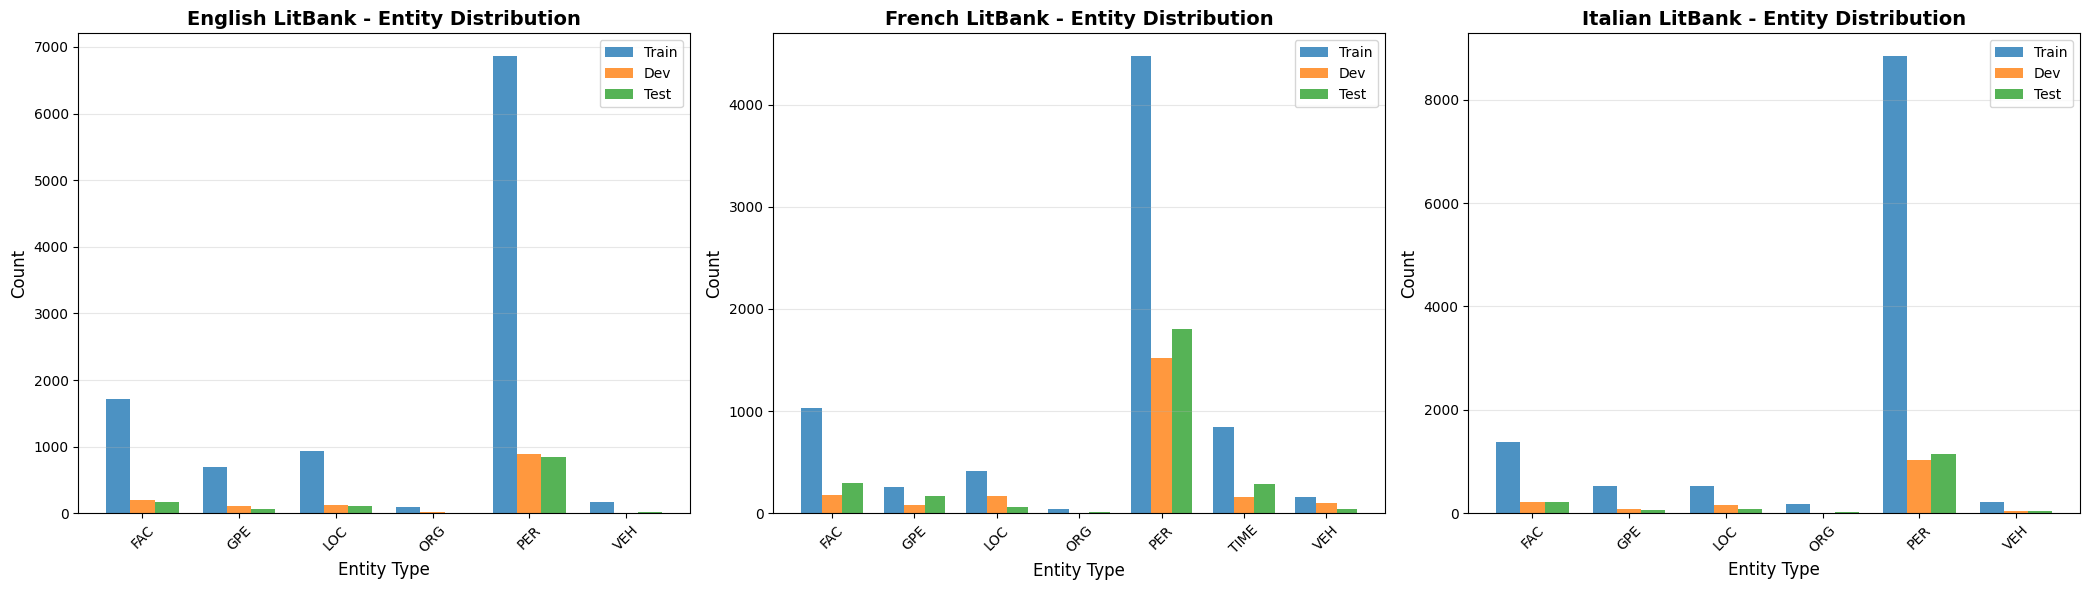

In [32]:
def plot_entity_distribution_multilingual(english_stats: Dict, french_stats: Dict = None, italian_stats: Dict = None):
    """Create comparative bar chart of entity distributions for all languages."""
    # Count available languages
    num_languages = 1 + (1 if french_stats else 0) + (1 if italian_stats else 0)
    
    fig, axes = plt.subplots(1, num_languages, figsize=(7 * num_languages, 6))
    if num_languages == 1:
        axes = [axes]
    
    width = 0.25
    ax_idx = 0
    
    # English plot
    entity_types = sorted(set(
        list(english_stats['train']['entity_distribution'].keys()) +
        list(english_stats['dev']['entity_distribution'].keys()) +
        list(english_stats['test']['entity_distribution'].keys())
    ))
    
    train_counts = [english_stats['train']['entity_distribution'].get(et, 0) for et in entity_types]
    dev_counts = [english_stats['dev']['entity_distribution'].get(et, 0) for et in entity_types]
    test_counts = [english_stats['test']['entity_distribution'].get(et, 0) for et in entity_types]
    
    x = range(len(entity_types))
    
    axes[ax_idx].bar([i - width for i in x], train_counts, width, label='Train', alpha=0.8)
    axes[ax_idx].bar(x, dev_counts, width, label='Dev', alpha=0.8)
    axes[ax_idx].bar([i + width for i in x], test_counts, width, label='Test', alpha=0.8)
    
    axes[ax_idx].set_xlabel('Entity Type', fontsize=12)
    axes[ax_idx].set_ylabel('Count', fontsize=12)
    axes[ax_idx].set_title('English LitBank - Entity Distribution', fontsize=14, fontweight='bold')
    axes[ax_idx].set_xticks(x)
    axes[ax_idx].set_xticklabels(entity_types, rotation=45)
    axes[ax_idx].legend()
    axes[ax_idx].grid(axis='y', alpha=0.3)
    ax_idx += 1
    
    # French plot
    if french_stats:
        entity_types_fr = sorted(set(
            list(french_stats['train']['entity_distribution'].keys()) +
            list(french_stats['dev']['entity_distribution'].keys()) +
            list(french_stats['test']['entity_distribution'].keys())
        ))
        
        train_counts_fr = [french_stats['train']['entity_distribution'].get(et, 0) for et in entity_types_fr]
        dev_counts_fr = [french_stats['dev']['entity_distribution'].get(et, 0) for et in entity_types_fr]
        test_counts_fr = [french_stats['test']['entity_distribution'].get(et, 0) for et in entity_types_fr]
        
        x_fr = range(len(entity_types_fr))
        
        axes[ax_idx].bar([i - width for i in x_fr], train_counts_fr, width, label='Train', alpha=0.8)
        axes[ax_idx].bar(x_fr, dev_counts_fr, width, label='Dev', alpha=0.8)
        axes[ax_idx].bar([i + width for i in x_fr], test_counts_fr, width, label='Test', alpha=0.8)
        
        axes[ax_idx].set_xlabel('Entity Type', fontsize=12)
        axes[ax_idx].set_ylabel('Count', fontsize=12)
        axes[ax_idx].set_title('French LitBank - Entity Distribution', fontsize=14, fontweight='bold')
        axes[ax_idx].set_xticks(x_fr)
        axes[ax_idx].set_xticklabels(entity_types_fr, rotation=45)
        axes[ax_idx].legend()
        axes[ax_idx].grid(axis='y', alpha=0.3)
        ax_idx += 1
    
    # Italian plot
    if italian_stats:
        entity_types_it = sorted(set(
            list(italian_stats['train']['entity_distribution'].keys()) +
            list(italian_stats['dev']['entity_distribution'].keys()) +
            list(italian_stats['test']['entity_distribution'].keys())
        ))
        
        train_counts_it = [italian_stats['train']['entity_distribution'].get(et, 0) for et in entity_types_it]
        dev_counts_it = [italian_stats['dev']['entity_distribution'].get(et, 0) for et in entity_types_it]
        test_counts_it = [italian_stats['test']['entity_distribution'].get(et, 0) for et in entity_types_it]
        
        x_it = range(len(entity_types_it))
        
        axes[ax_idx].bar([i - width for i in x_it], train_counts_it, width, label='Train', alpha=0.8)
        axes[ax_idx].bar(x_it, dev_counts_it, width, label='Dev', alpha=0.8)
        axes[ax_idx].bar([i + width for i in x_it], test_counts_it, width, label='Test', alpha=0.8)
        
        axes[ax_idx].set_xlabel('Entity Type', fontsize=12)
        axes[ax_idx].set_ylabel('Count', fontsize=12)
        axes[ax_idx].set_title('Italian LitBank - Entity Distribution', fontsize=14, fontweight='bold')
        axes[ax_idx].set_xticks(x_it)
        axes[ax_idx].set_xticklabels(entity_types_it, rotation=45)
        axes[ax_idx].legend()
        axes[ax_idx].grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    
    save_path = RESULTS_PATH / "entity_distribution_multilingual.png"
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    print(f"\n✓ Saved plot to {save_path}")
    plt.show()

# Create visualization
plot_entity_distribution_multilingual(english_stats, french_stats, italian_stats)

## 11. Entity Length Analysis

Analyses the length of entities (number of tokens per entity) for each dataset and entity type.

In [33]:
def compute_entity_lengths(data: List[Dict]) -> Dict[str, List[int]]:
    """
    Compute entity lengths for each entity type.
    An entity length is the count of tokens: 1 B-tag + N I-tags.
    
    Returns a dict mapping entity_type -> list of entity lengths.
    """
    entity_lengths = defaultdict(list)
    
    for example in data:
        labels = example["labels"]
        i = 0
        while i < len(labels):
            label = labels[i]
            if label.startswith('B-'):
                entity_type = label[2:]
                length = 1
                # Count following I-tags of the same type
                j = i + 1
                while j < len(labels) and labels[j] == f'I-{entity_type}':
                    length += 1
                    j += 1
                entity_lengths[entity_type].append(length)
                i = j
            else:
                i += 1
    
    return dict(entity_lengths)


def analyze_entity_lengths(data: List[Dict], language: str, split: str) -> pd.DataFrame:
    """
    Analyze entity lengths and return statistics per entity type.
    """
    entity_lengths = compute_entity_lengths(data)
    
    results = []
    for entity_type in sorted(entity_lengths.keys()):
        lengths = entity_lengths[entity_type]
        if lengths:
            results.append({
                'language': language,
                'split': split,
                'entity_type': entity_type,
                'count': len(lengths),
                'mean_length': round(sum(lengths) / len(lengths), 2),
                'max_length': max(lengths),
                'min_length': min(lengths)
            })
    
    return pd.DataFrame(results)


# Compute entity length statistics for all datasets
print("ENTITY LENGTH ANALYSIS")

all_length_stats = []

# English
for split_name, split_data in [('train', english_train), ('dev', english_dev), ('test', english_test)]:
    df = analyze_entity_lengths(split_data, 'English', split_name)
    all_length_stats.append(df)

# French
if french_train:
    for split_name, split_data in [('train', french_train), ('dev', french_dev), ('test', french_test)]:
        df = analyze_entity_lengths(split_data, 'French', split_name)
        all_length_stats.append(df)

# Italian
if italian_train:
    for split_name, split_data in [('train', italian_train), ('dev', italian_dev), ('test', italian_test)]:
        df = analyze_entity_lengths(split_data, 'Italian', split_name)
        all_length_stats.append(df)

# Combine all statistics
entity_length_df = pd.concat(all_length_stats, ignore_index=True)

# Display results by language
for language in ['English', 'French', 'Italian']:
    lang_df = entity_length_df[entity_length_df['language'] == language]
    if not lang_df.empty:
        print(f"\n{language.upper()} - Entity Length Statistics:")
        
        # Pivot to show all splits side by side
        for entity_type in sorted(lang_df['entity_type'].unique()):
            et_df = lang_df[lang_df['entity_type'] == entity_type]
            print(f"\n  {entity_type}:")
            for _, row in et_df.iterrows():
                print(f"    {row['split']:5s}: count={row['count']:5d}, "
                      f"mean={row['mean_length']:5.2f}, max={row['max_length']:3d}")

# Save to CSV
entity_length_path = RESULTS_PATH / "entity_length_statistics.csv"
entity_length_df.to_csv(entity_length_path, index=False)
print(f"\n\n✓ Saved entity length statistics to {entity_length_path}")

# Create a summary table aggregated across splits (per language)
print("\nSUMMARY: Entity Lengths by Language (aggregated across all splits)")

summary_rows = []
for language in ['English', 'French', 'Italian']:
    lang_data = []
    if language == 'English':
        lang_data = english_train + english_dev + english_test
    elif language == 'French' and french_train:
        lang_data = french_train + french_dev + french_test
    elif language == 'Italian' and italian_train:
        lang_data = italian_train + italian_dev + italian_test
    
    if lang_data:
        entity_lengths = compute_entity_lengths(lang_data)
        for entity_type in sorted(entity_lengths.keys()):
            lengths = entity_lengths[entity_type]
            summary_rows.append({
                'language': language,
                'entity_type': entity_type,
                'total_entities': len(lengths),
                'mean_length': round(sum(lengths) / len(lengths), 2),
                'max_length': max(lengths)
            })

summary_df = pd.DataFrame(summary_rows)

# Display as a formatted table
print("\n" + summary_df.to_string(index=False))

ENTITY LENGTH ANALYSIS

ENGLISH - Entity Length Statistics:

  FAC:
    train: count= 1712, mean= 2.82, max= 40
    dev  : count=  200, mean= 3.04, max= 32
    test : count=  163, mean= 2.48, max= 10

  GPE:
    train: count=  699, mean= 1.81, max= 22
    dev  : count=  111, mean= 1.77, max=  9
    test : count=   60, mean= 1.57, max=  7

  LOC:
    train: count=  937, mean= 3.00, max= 33
    dev  : count=  122, mean= 3.67, max= 15
    test : count=  107, mean= 2.71, max=  9

  ORG:
    train: count=   98, mean= 3.00, max= 11
    dev  : count=   23, mean= 5.00, max= 12
    test : count=    6, mean= 2.33, max=  4

  PER:
    train: count= 6862, mean= 2.84, max= 78
    dev  : count=  887, mean= 2.91, max= 34
    test : count=  839, mean= 2.66, max= 32

  VEH:
    train: count=  167, mean= 2.57, max= 15
    dev  : count=    8, mean= 2.38, max=  3
    test : count=   16, mean= 2.56, max=  5

FRENCH - Entity Length Statistics:

  FAC:
    train: count= 1034, mean= 3.00, max= 23
    dev  : c


✓ Saved entity length visualization to ../results/entity_lengths_by_language.png


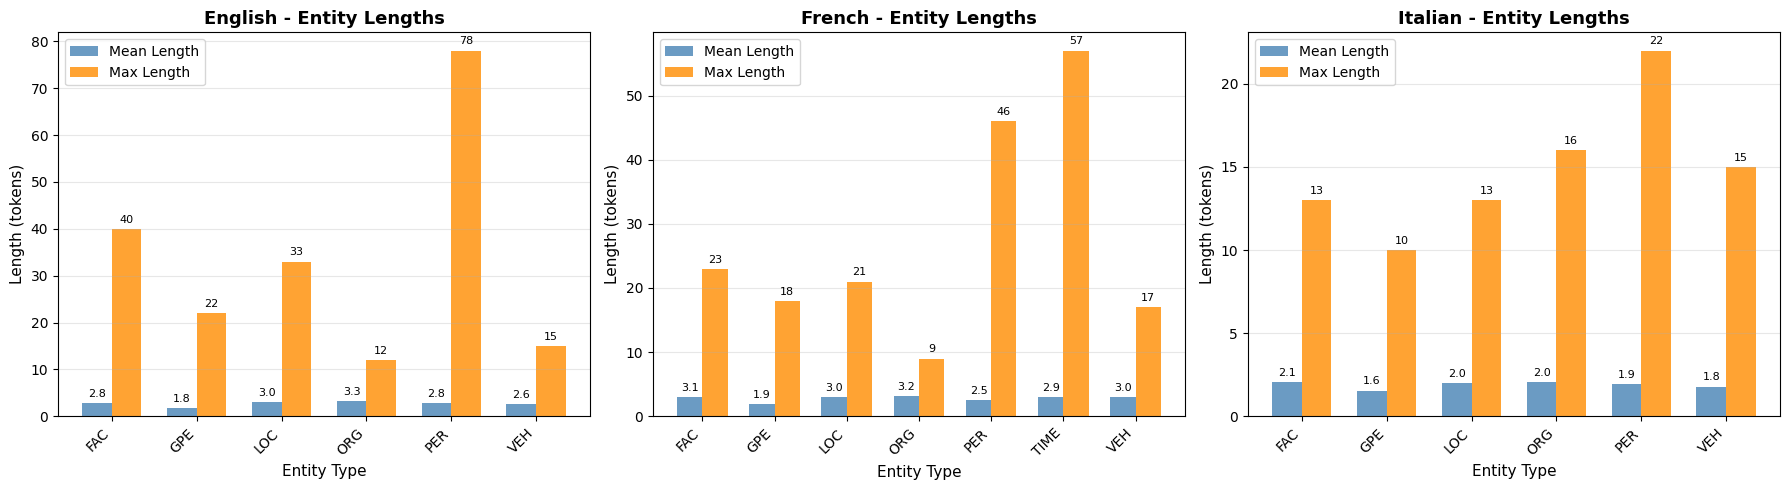

In [34]:
# Visualize entity lengths by language
def plot_entity_lengths(summary_df: pd.DataFrame):
    """
    Create bar charts showing mean and max entity lengths for each language.
    """
    languages = summary_df['language'].unique()
    num_languages = len(languages)
    
    fig, axes = plt.subplots(1, num_languages, figsize=(6 * num_languages, 5))
    if num_languages == 1:
        axes = [axes]
    
    width = 0.35
    
    for ax_idx, language in enumerate(languages):
        lang_df = summary_df[summary_df['language'] == language].sort_values('entity_type')
        
        entity_types = lang_df['entity_type'].tolist()
        mean_lengths = lang_df['mean_length'].tolist()
        max_lengths = lang_df['max_length'].tolist()
        
        x = range(len(entity_types))
        
        bars1 = axes[ax_idx].bar([i - width/2 for i in x], mean_lengths, width, 
                                  label='Mean Length', color='steelblue', alpha=0.8)
        bars2 = axes[ax_idx].bar([i + width/2 for i in x], max_lengths, width, 
                                  label='Max Length', color='darkorange', alpha=0.8)
        
        # Add value labels on bars
        for bar in bars1:
            height = bar.get_height()
            axes[ax_idx].annotate(f'{height:.1f}',
                                   xy=(bar.get_x() + bar.get_width() / 2, height),
                                   xytext=(0, 3), textcoords="offset points",
                                   ha='center', va='bottom', fontsize=8)
        
        for bar in bars2:
            height = bar.get_height()
            axes[ax_idx].annotate(f'{int(height)}',
                                   xy=(bar.get_x() + bar.get_width() / 2, height),
                                   xytext=(0, 3), textcoords="offset points",
                                   ha='center', va='bottom', fontsize=8)
        
        axes[ax_idx].set_xlabel('Entity Type', fontsize=11)
        axes[ax_idx].set_ylabel('Length (tokens)', fontsize=11)
        axes[ax_idx].set_title(f'{language} - Entity Lengths', fontsize=13, fontweight='bold')
        axes[ax_idx].set_xticks(x)
        axes[ax_idx].set_xticklabels(entity_types, rotation=45, ha='right')
        axes[ax_idx].legend(loc='upper left')
        axes[ax_idx].grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    
    save_path = RESULTS_PATH / "entity_lengths_by_language.png"
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    print(f"\n✓ Saved entity length visualization to {save_path}")
    plt.show()

# Create the visualization
plot_entity_lengths(summary_df)

In [35]:
# Find and display the maximum length entity examples for each language (with filenames)

def find_max_length_entities_english(base_path: Path) -> Dict:
    """
    Find max length entities from English TSV files, tracking filenames.
    """
    max_entities = {}  # entity_type -> (length, entity_tokens, context, filename)
    
    for split in ['train', 'dev', 'test']:
        split_path = base_path / split
        for tsv_file in split_path.glob('*.tsv'):
            tokens, labels = load_bio_file(tsv_file)
            
            i = 0
            while i < len(labels):
                label = labels[i]
                if label.startswith('B-'):
                    entity_type = label[2:]
                    start_idx = i
                    length = 1
                    
                    j = i + 1
                    while j < len(labels) and labels[j] == f'I-{entity_type}':
                        length += 1
                        j += 1
                    end_idx = j
                    
                    entity_tokens = tokens[start_idx:end_idx]
                    
                    if entity_type not in max_entities or length > max_entities[entity_type][0]:
                        # Get context window
                        ctx_start = max(0, start_idx - 5)
                        ctx_end = min(len(tokens), end_idx + 5)
                        max_entities[entity_type] = (
                            length, entity_tokens, tokens[ctx_start:ctx_end],
                            labels[ctx_start:ctx_end], start_idx - ctx_start,
                            tsv_file.stem, split
                        )
                    i = j
                else:
                    i += 1
    
    return max_entities


def find_max_length_entities_brat(base_path: Path, entity_mapping: Dict, drop_types: set) -> Dict:
    """
    Find max length entities from BRAT files, tracking filenames.
    """
    max_entities = {}
    converter = BratToBioConverter(entity_mapping=entity_mapping, drop_types=drop_types)
    
    for txt_file in base_path.glob('*.txt'):
        ann_file = txt_file.with_suffix('.ann')
        if not ann_file.exists():
            continue
        
        data = converter.convert_file(txt_file, ann_file)
        tokens = data['tokens']
        labels = data['labels']
        filename = data['filename']
        
        i = 0
        while i < len(labels):
            label = labels[i]
            if label.startswith('B-'):
                entity_type = label[2:]
                start_idx = i
                length = 1
                
                j = i + 1
                while j < len(labels) and labels[j] == f'I-{entity_type}':
                    length += 1
                    j += 1
                end_idx = j
                
                entity_tokens = tokens[start_idx:end_idx]
                
                if entity_type not in max_entities or length > max_entities[entity_type][0]:
                    ctx_start = max(0, start_idx - 5)
                    ctx_end = min(len(tokens), end_idx + 5)
                    max_entities[entity_type] = (
                        length, entity_tokens, tokens[ctx_start:ctx_end],
                        labels[ctx_start:ctx_end], start_idx - ctx_start,
                        filename, None
                    )
                i = j
            else:
                i += 1
    
    return max_entities


def print_max_length_examples_with_source(max_entities: Dict, language: str):
    """
    Print the maximum length entity examples with source filename.
    """
    print(f"\n{language.upper()} - Maximum Length Entity Examples")
    
    for entity_type in sorted(max_entities.keys()):
        length, entity_tokens, context_tokens, context_labels, entity_offset, filename, split = max_entities[entity_type]
        
        entity_str = ' '.join(entity_tokens)
        
        # Mark the entity in context
        marked_context = []
        for idx, tok in enumerate(context_tokens):
            if entity_offset <= idx < entity_offset + length:
                marked_context.append(f"[{tok}]")
            else:
                marked_context.append(tok)
        
        source_info = f"{filename}" + (f" ({split})" if split else "")
        
        print(f"\n  {entity_type} (max length: {length} tokens):")
        print(f"    Source:  {source_info}")
        print(f"    Entity:  \"{entity_str}\"")
        print(f"    Context: {' '.join(marked_context)}")


# Find and print max length examples for each language
print("\nSearching for maximum length entities in raw files...")

# English
english_max = find_max_length_entities_english(RAW_DATA_PATH / "english")
print_max_length_examples_with_source(english_max, "English")

# French
french_brat_dir = RAW_DATA_PATH / "french_brat"
if french_brat_dir.exists() and list(french_brat_dir.glob('*.txt')):
    french_max = find_max_length_entities_brat(french_brat_dir, FRENCH_ENTITY_MAPPING, FRENCH_DROP_TYPES)
    print_max_length_examples_with_source(french_max, "French")

# Italian
italian_brat_dir = RAW_DATA_PATH / "italian_brat"
if italian_brat_dir.exists() and list(italian_brat_dir.glob('*.txt')):
    italian_max = find_max_length_entities_brat(italian_brat_dir, ITALIAN_ENTITY_MAPPING, ITALIAN_DROP_TYPES)
    print_max_length_examples_with_source(italian_max, "Italian")


Searching for maximum length entities in raw files...

ENGLISH - Maximum Length Entity Examples

  FAC (max length: 40 tokens):
    Source:  8867_the_magnificent_ambersons (train)
    Entity:  "each of these rooms containing a double bed , a “ washstand , ” a “ bureau , ” a wardrobe , a little table , a rocking-chair , and often a chair or two that had been slightly damaged"
    Context: one or two daughters ; [each] [of] [these] [rooms] [containing] [a] [double] [bed] [,] [a] [“] [washstand] [,] [”] [a] [“] [bureau] [,] [”] [a] [wardrobe] [,] [a] [little] [table] [,] [a] [rocking-chair] [,] [and] [often] [a] [chair] [or] [two] [that] [had] [been] [slightly] [damaged] downstairs , but not enough

  GPE (max length: 22 tokens):
    Source:  550_silas_marner (train)
    Entity:  "a village which showed at once the summits of its social life , and told the practised eye that there was no"
    Context: of the churchyard : -- [a] [village] [which] [showed] [at] [once] [the] [summits] [of] 

## 12. Entity type examples
Display the most frequent entities among the shorter ones.

In [36]:
# Find most frequent entities by word count for each language and entity type
from collections import Counter

def extract_entities_with_text(data: List[Dict]) -> List[Tuple[str, str, int]]:
    """
    Extract all entities with their text from a dataset.
    Returns a list of (entity_type, entity_text, word_count) tuples.
    """
    entities = []
    
    for example in data:
        tokens = example["tokens"]
        labels = example["labels"]
        
        i = 0
        while i < len(labels):
            label = labels[i]
            if label.startswith('B-'):
                entity_type = label[2:]
                start_idx = i
                
                # Find the end of the entity
                j = i + 1
                while j < len(labels) and labels[j] == f'I-{entity_type}':
                    j += 1
                end_idx = j
                
                entity_tokens = tokens[start_idx:end_idx]
                entity_text = ' '.join(entity_tokens)
                entities.append((entity_type, entity_text, len(entity_tokens)))
                
                i = j
            else:
                i += 1
    
    return entities


def get_most_frequent_by_word_count(entities: List[Tuple[str, str, int]], 
                                     entity_type: str, 
                                     word_count: int, 
                                     top_n: int = 5) -> List[Tuple[str, int]]:
    """
    Get the most frequent entities of a specific type with exactly word_count words.
    """
    filtered = [text for etype, text, wc in entities 
                if etype == entity_type and wc == word_count]
    return Counter(filtered).most_common(top_n)


def display_frequent_entities_by_length(language_name: str, 
                                         train_data: List[Dict],
                                         dev_data: List[Dict],
                                         test_data: List[Dict]):
    """
    Display the most frequent 1-word, 2-word, and 3-word entities for each entity type.
    """
    # Combine all splits
    all_data = train_data + dev_data + test_data
    entities = extract_entities_with_text(all_data)
    
    # Get unique entity types present in this dataset
    entity_types_present = sorted(set(etype for etype, _, _ in entities))
    
    print(f"\n{language_name.upper()} - Most Frequent Entities by Word Count")
    
    for entity_type in entity_types_present:
        print(f"  {entity_type}:")
        
        for word_count in [1, 2, 3]:
            top_entities = get_most_frequent_by_word_count(entities, entity_type, word_count)
            
            if top_entities:
                word_label = f"{word_count}-word" if word_count == 1 else f"{word_count}-words"
                print(f"    {word_label}:")
                for entity_text, count in top_entities:
                    print(f'      "{entity_text}" ({count}x)')
            else:
                word_label = f"{word_count}-word" if word_count == 1 else f"{word_count}-words"
                print(f"    {word_label}: (none)")


# Display for English
display_frequent_entities_by_length("English", english_train, english_dev, english_test)

# Display for French
if french_train:
    display_frequent_entities_by_length("French", french_train, french_dev, french_test)

# Display for Italian
if italian_train:
    display_frequent_entities_by_length("Italian", italian_train, italian_dev, italian_test)


ENGLISH - Most Frequent Entities by Word Count
  FAC:
    1-word:
      "home" (64x)
      "there" (39x)
      "here" (39x)
      "upstairs" (12x)
      "downstairs" (10x)
    2-words:
      "the house" (53x)
      "the room" (34x)
      "the garden" (22x)
      "the street" (14x)
      "the road" (13x)
    3-words:
      "the drug store" (4x)
      "the next station" (3x)
      "the streets of" (3x)
      "the houses of" (2x)
      "the seven chambers" (2x)
  GPE:
    1-word:
      "London" (40x)
      "England" (31x)
      "there" (21x)
      "town" (14x)
      "France" (13x)
    2-words:
      "the town" (21x)
      "New York" (16x)
      "the country" (10x)
      "the place" (8x)
      "that country" (7x)
    3-words:
      "the Southern States" (3x)
      "the Midland town" (2x)
      "my native country" (2x)
      "Leichardt 's Town" (2x)
      "Leichardt 's Land" (2x)
  LOC:
    1-word:
      "there" (18x)
      "sea" (16x)
      "Mars" (9x)
      "here" (8x)
      "desert" (5x

## 13. Save Processed Datasets

In [37]:
def save_dataset(data: List[Dict], output_path: Path, label2id: Dict[str, int], language: str):
    """Save dataset to JSON with integer label IDs."""
    processed_data = []
    for example in data:
        processed_data.append({
            "tokens": example["tokens"],
            "ner_tags": [label2id[label] for label in example["labels"]],
            "language": language
        })
    
    with open(output_path, 'w', encoding='utf-8') as f:
        json.dump(processed_data, f, indent=2, ensure_ascii=False)
    
    print(f"  ✓ Saved {len(processed_data):,} examples to {output_path.name}")

print("SAVING PROCESSED DATASETS")

# Save English datasets
print("\nEnglish datasets:")
save_dataset(english_train, PROCESSED_DATA_PATH / "english_train.json", label2id, "en")
save_dataset(english_dev, PROCESSED_DATA_PATH / "english_dev.json", label2id, "en")
save_dataset(english_test, PROCESSED_DATA_PATH / "english_test.json", label2id, "en")

# Save French datasets
if french_train:
    print("\nFrench datasets:")
    save_dataset(french_train, PROCESSED_DATA_PATH / "french_train.json", label2id, "fr")
    save_dataset(french_dev, PROCESSED_DATA_PATH / "french_dev.json", label2id, "fr")
    save_dataset(french_test, PROCESSED_DATA_PATH / "french_test.json", label2id, "fr")

# Save Italian datasets
if italian_train:
    print("\nItalian datasets:")
    save_dataset(italian_train, PROCESSED_DATA_PATH / "italian_train.json", label2id, "it")
    save_dataset(italian_dev, PROCESSED_DATA_PATH / "italian_dev.json", label2id, "it")
    save_dataset(italian_test, PROCESSED_DATA_PATH / "italian_test.json", label2id, "it")

# Build languages list
languages = ["en"]
if french_train:
    languages.append("fr")
if italian_train:
    languages.append("it")

# Save label mapping
label_mapping = {
    "label2id": label2id,
    "id2label": id2label,
    "num_labels": len(label2id),
    "entity_types": entity_types,
    "languages": languages
}

with open(PROCESSED_DATA_PATH / "label_mapping.json", 'w', encoding='utf-8') as f:
    json.dump(label_mapping, f, indent=2, ensure_ascii=False)

print(f"\n  ✓ Saved label mapping to label_mapping.json")

print("\nALL DATA SAVED SUCCESSFULLY")
print(f"Location: {PROCESSED_DATA_PATH.absolute()}")

SAVING PROCESSED DATASETS

English datasets:
  ✓ Saved 5,577 examples to english_train.json
  ✓ Saved 747 examples to english_dev.json
  ✓ Saved 693 examples to english_test.json

French datasets:
  ✓ Saved 5,115 examples to french_train.json
  ✓ Saved 1,274 examples to french_dev.json
  ✓ Saved 1,460 examples to french_test.json

Italian datasets:
  ✓ Saved 7,493 examples to italian_train.json
  ✓ Saved 927 examples to italian_dev.json
  ✓ Saved 840 examples to italian_test.json

  ✓ Saved label mapping to label_mapping.json

ALL DATA SAVED SUCCESSFULLY
Location: /storage/homefs/nw03x063/CAS_Mod4_NER/notebooks/../data/processed


## 12. Summary and Dataset Comparison

In [38]:
print("MULTILINGUAL DATASET SUMMARY")

print("\nOVERALL STATISTICS:")
print("\nEnglish LitBank:")
print(f"  Train: {len(english_train):,} examples, {english_stats['train']['total_tokens']:,} tokens")
print(f"  Dev:   {len(english_dev):,} examples, {english_stats['dev']['total_tokens']:,} tokens")
print(f"  Test:  {len(english_test):,} examples, {english_stats['test']['total_tokens']:,} tokens")
print(f"  Entity types: {sorted(english_stats['train']['entity_distribution'].keys())}")

if french_stats:
    print("\nFrench LitBank:")
    print(f"  Train: {len(french_train):,} examples, {french_stats['train']['total_tokens']:,} tokens")
    print(f"  Dev:   {len(french_dev):,} examples, {french_stats['dev']['total_tokens']:,} tokens")
    print(f"  Test:  {len(french_test):,} examples, {french_stats['test']['total_tokens']:,} tokens")
    print(f"  Entity types: {sorted(french_stats['train']['entity_distribution'].keys())}")

if italian_stats:
    print("\nItalian LitBank:")
    print(f"  Train: {len(italian_train):,} examples, {italian_stats['train']['total_tokens']:,} tokens")
    print(f"  Dev:   {len(italian_dev):,} examples, {italian_stats['dev']['total_tokens']:,} tokens")
    print(f"  Test:  {len(italian_test):,} examples, {italian_stats['test']['total_tokens']:,} tokens")
    print(f"  Entity types: {sorted(italian_stats['train']['entity_distribution'].keys())}")

print("\nShared resources:")
print("  • label_mapping.json - Unified label mappings")
print("  • entity_distribution_multilingual.png - Visualization")

MULTILINGUAL DATASET SUMMARY

OVERALL STATISTICS:

English LitBank:
  Train: 5,577 examples, 169,456 tokens
  Dev:   747 examples, 20,438 tokens
  Test:  693 examples, 20,638 tokens
  Entity types: ['FAC', 'GPE', 'LOC', 'ORG', 'PER', 'VEH']

French LitBank:
  Train: 5,115 examples, 154,874 tokens
  Dev:   1,274 examples, 37,240 tokens
  Test:  1,460 examples, 42,958 tokens
  Entity types: ['FAC', 'GPE', 'LOC', 'ORG', 'PER', 'TIME', 'VEH']

Italian LitBank:
  Train: 7,493 examples, 208,845 tokens
  Dev:   927 examples, 25,640 tokens
  Test:  840 examples, 25,356 tokens
  Entity types: ['FAC', 'GPE', 'LOC', 'ORG', 'PER', 'VEH']

Shared resources:
  • label_mapping.json - Unified label mappings
  • entity_distribution_multilingual.png - Visualization


## 13. Data Quality Checks

In [39]:
def verify_data_quality(data: List[Dict], language: str):
    """Verify data quality and consistency."""
    print(f"\nVerifying {language} data quality...")
    
    # Check for empty examples
    empty_examples = [i for i, ex in enumerate(data) if not ex['tokens']]
    if empty_examples:
        print(f"  ⚠️  Found {len(empty_examples)} empty examples")
    else:
        print("  ✓ No empty examples")
    
    # Check token-label alignment
    misaligned = [(i, len(ex['tokens']), len(ex['labels'])) 
                  for i, ex in enumerate(data) 
                  if len(ex['tokens']) != len(ex['labels'])]
    if misaligned:
        print(f"  ⚠️  Found {len(misaligned)} misaligned examples")
        print(f"      Example: index {misaligned[0][0]} has {misaligned[0][1]} tokens, {misaligned[0][2]} labels")
    else:
        print("  ✓ All examples have aligned tokens and labels")
    
    # Check label validity
    invalid_labels = set()
    for ex in data:
        for label in ex['labels']:
            if label not in label2id:
                invalid_labels.add(label)
    
    if invalid_labels:
        print(f"  ⚠️  Found invalid labels: {invalid_labels}")
    else:
        print("  ✓ All labels are valid")
    
    # Check for extremely long sequences
    max_length = max(len(ex['tokens']) for ex in data) if data else 0
    very_long = [i for i, ex in enumerate(data) if len(ex['tokens']) > 512]
    print(f"  • Max sequence length: {max_length}")
    if very_long:
        print(f"  ⚠️  {len(very_long)} examples exceed 512 tokens (may need truncation)")

print("DATA QUALITY VERIFICATION")

verify_data_quality(english_train, "English")
if french_train:
    verify_data_quality(french_train, "French")
if italian_train:
    verify_data_quality(italian_train, "Italian")

DATA QUALITY VERIFICATION

Verifying English data quality...
  ✓ No empty examples
  ✓ All examples have aligned tokens and labels
  ✓ All labels are valid
  • Max sequence length: 307

Verifying French data quality...
  ✓ No empty examples
  ✓ All examples have aligned tokens and labels
  ✓ All labels are valid
  • Max sequence length: 200

Verifying Italian data quality...
  ✓ No empty examples
  ✓ All examples have aligned tokens and labels
  ✓ All labels are valid
  • Max sequence length: 251
